# Build a CV model to Identify Road Surfaces in Street Level Imagery (SLI)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[![Download](images/download.png)][2][<sub>Download this Notebook</sub>][2]

[1]: https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/example_sli_api.ipynb
[2]: https://docs.masterfulai.com/0.5.2/notebooks/example_sli_api.ipynb

In this example application, you'll design and implement an ML model to tackle a real world problem. 

The following is the breakdown of the process:

1. Defining the application
2. Preparing the data
3. Choosing model architecture
4. Training the model
5. Deployment

## Define the Application

The first step to any ML project is to define the application you are trying to build. You'll need to define the task of the model, as well as the requirements of how the
model should be interacted with. 

In this case, you'd like to build a CV model that can take an image a street taken from a car (aka Street Level Imagery or SLI) and identify which parts of that image are okay to drive on. Training such a model could become the heart of an Advanced Driver Assistance System: using cameras and deep learning, a model like this could alert a driver if their car is about to go off the road. 

Since you are trying to classify fine-grained parts of our image, down to pixels, the CV task is **semantic segmentation**. Other CV tasks include detection (bounding boxes), keypoint detection, and classification (what's in the picture as a whole). The decision on which CV task is applicable will define how you build your model and how you label data.

In terms of model interaction, models can either be deployed remotely on the cloud or locally on the device. A lot of factors come into play when making this decision, such as latency, privacy, and performance. This decision is important for designing the model, as models intended for local deployment usually have much more constraints than remote deployment, which allow the model to utilize much stronger hardware.

In this case, assume the device has the ability to connect to the Internet and send inference requests remotely. So you'll deploy the model to a server.

## Prepare The Data

The key ingredient for any ML model is data. A deep learning CV model will generally need a minimum of 1,000 examples, and possibly many more, to converge at all. 

In practice, you might need to get up from your desk and spend a few days taking photos with your phone, or scrape the web. Then, you'll need to label those images. For the first batch of images, it is helpful to label them yourself. You'll learn a lot about the data and that knowledge will go into the labeling guide you'll eventually share with dedicated labelers. You'll only need Google Sheets to track classification labels, but for detection or segmentation, try an open source tool like [Label Studio](https://github.com/heartexlabs/label-studio).

For the purposes of this guide, you'll use an existing academic labeled dataset, Cityscapes, to skip the manual data acquisition and labeling work. Cityscapes is a dataset consisting of street scenes from 50 different cities and comes with segmentation-mask groundtruth.

Go to the [Cityscapes Dataset Website](https://www.cityscapes-dataset.com/downloads) and create an account. Then use your credentials to download the two zip files from the command line.

In [ ]:
! wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=<<<fill_in_here>>>&password=<<<fill_in_here>>>&submit=Login' https://www.cityscapes-dataset.com/login/

# gtFine_trainvaltest.zip : Fine annotations for the above train and val set (3475 annotated images)
! wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

# leftImg8bit_trainvaltest.zip (11GB): Training (2975 images), Val (500) and Test (1525) set.
! wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

# Unzip both leftImg8bit_trainvaltest.zip and gtFine_trainvaltest.zip into the current working directory.
# delete any prior READMEs and license.txt (if exists)
! test -e README && rm README; test -e license.txt && rm license.txt; test -e leftImg8bit/ && rm -rf leftImg8bit/
! unzip -q leftImg8bit_trainvaltest.zip

# delete any prior READMEs and license.txt (if exists)
! test -e README && rm README; test -e license.txt && rm license.txt; test -e gtFine/ && rm -rf gtFine/
! unzip -q gtFine_trainvaltest.zip

--2022-06-21 22:32:54--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2022-06-21 22:32:55--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html.tmp’

index.html.tmp          [ <=>                ]  47.35K  --.-KB/s    in 0.1s    

2022-06-21 22:32:56 (348 KB/s) - ‘index.html.tmp’ saved [48483]

Removing index.html.tmp.
--2022-06-21 22:32:56--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cit

### Import Packages. 

Now that the dataset is on disk, you'll write some data wrangling code to access it.

Start by importing necessary packages. 

In [4]:
import os
import re
import glob
import signal
import masterful
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
masterful = masterful.activate()

try:
    import cv2
except ImportError:
    print("Installing opencv-contrib-python==4.5.1.48")
    bashCommand = "pip install opencv-contrib-python==4.5.1.48"
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    output = output.decode("utf-8").strip()
    if error:
        print("Failed to import 'cv2'. Stop further execution")
        print(output)
    else:
        import cv2

### Parse filenames from the directory structure. 

In [2]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 1


root = '.'

# A map from data type to folder name that saves the data.
_FOLDERS_MAP = {
    'image': 'leftImg8bit',
    'label': 'gtFine',
}

# A map from data type to filename postfix.
_POSTFIX_MAP = {
    'image': '_leftImg8bit',
    'label': '_gtFine_labelIds',
}

# A map from data type to data format.
_DATA_FORMAT_MAP = {
    'image': 'png',
    'label': 'png',
}

_IMAGE_FILENAME_RE = re.compile('(.+)' + _POSTFIX_MAP['image'])

train = {
    'image':[],
    'label':[],
}
test = {
    'image':[],
    'label':[],
}
unused = {
    'image':[],
    'label':[],
}

for data in ['image', 'label']:
    for split_dir in ['train', 'val', 'test']:
        pattern = '*%s.%s' % (_POSTFIX_MAP[data], _DATA_FORMAT_MAP[data])
        search_files = os.path.join(root, _FOLDERS_MAP[data], split_dir, '*', pattern)
        filenames = glob.glob(search_files)
        img_list = sorted(filenames)
        
        if split_dir == 'train':
            train[data].extend(img_list)
        elif split_dir == 'val':
            test[data].extend(img_list)
        elif split_dir == 'test':
            # these are the samples with no actual pixel-wise labels,
            # so ignore them.
            continue

print(f"# train samples = {len(train['label'])}")
print(f"# test samples = {len(test['label'])}")

# train samples = 2975
# test samples = 500


Note that original cityscapes dataset has 37 classes, but since you defined the application solely as detecting road surfaces, your code will only extract class 7, road surfaces, from the ground truth. 

### Reduce your dataset sizes

In general, you'll want to train start training your model on a subset of the available data just to get the code working. Once you have everything working end to end, then start increasing the dataset cardinalities to improve your model accuracy. 

Note that the cityscapes data comes with it's own "train", "val", and "test".

The Cityscapes "test" split comes with out-of-domain labels, so you won't use it.

The Cityscapes "validation" split is reported on in research, so you'll treat it as your test dataset.

In [3]:
# To save training time, train only on 10% of dataset. 
# After a model is converging, then increase the amount of data to improve accuracy. 

train_percentage = 10
test_percentage = 100
n_train = len(train[data])
n_test = len(test[data])


unused['image'] = train['image'][int(n_train * train_percentage / 100.):]
unused['label'] = train['label'][int(n_train * train_percentage / 100.):]

train['image'] = train['image'][:int(n_train * train_percentage / 100.)]
train['label'] = train['label'][:int(n_train * train_percentage / 100.)]

test['image'] = test['image'][:int(n_test * test_percentage / 100.)]
test['label'] = test['label'][:int(n_test * test_percentage / 100.)]

print(f"Train samples = {len(train['label'])}")
print(f"Test samples = {len(test['label'])}")
print(f"Unused samples = {len(unused['label'])}")

del unused

Train samples = 297
Test samples = 500
Unused samples = 2678


### Load into tf.data.Dataset

Previously, you saved the paths to images and labels of train and test set in train and test dictionaries respectively. You will use those paths to create train and test `tf.data.Dataset`s. 

In [4]:
train_image_path_ds = tf.data.Dataset.from_tensor_slices(train['image'])
train_label_path_ds = tf.data.Dataset.from_tensor_slices(train['label'])

test_image_path_ds = tf.data.Dataset.from_tensor_slices(test['image'])
test_label_path_ds = tf.data.Dataset.from_tensor_slices(test['label'])

train_image_label_path_ds = tf.data.Dataset.zip((train_image_path_ds, train_label_path_ds))
test_image_label_path_ds = tf.data.Dataset.zip((test_image_path_ds, test_label_path_ds))

### Apply pre-processing

Apply transformations that takes (image_path, label_path), and returns the preprocessed (image, label) pairs, in the same order as they appeared in the input.

In [5]:
def extract_image_and_label(image, label):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [INPUT_SHAPE[1], INPUT_SHAPE[0]])
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, [INPUT_SHAPE[1], INPUT_SHAPE[0]])
    label = tf.where(label == 7, tf.ones_like(label), tf.zeros_like(label))
    # Important: make sure the labels are of tf.float type.
    label = tf.cast(label, tf.float32)
    
    return image, label

def load_and_preprocess(image_path, label_path):
    image = tf.io.read_file(image_path)
    label = tf.io.read_file(label_path)
    return extract_image_and_label(image, label)
    
training_dataset = (
    train_image_label_path_ds
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
)

test_dataset = (
    test_image_label_path_ds
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
)

### Visualize the Data

Manually inspect the output of your data wrangling pipeline to look for any errors. With detection and segmentation in particular, masks and boxes can often fall out of alignment with the image due to different coordinate schemes. 

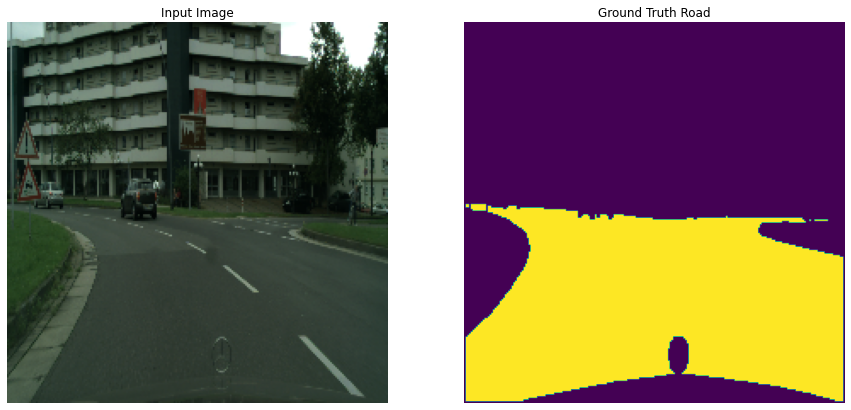

In [6]:
def display(display_list, pred=False):
    plt.figure(figsize=(15, 15))
    if pred and len(display_list) == 2:
        # we have display_list = [image, predicted_road]
        title = ['Input Image', 'Predicted Road']
    else:
        title = ['Input Image', 'Ground Truth Road', 'Predicted Road']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        # plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def scaleback_normalized_images(image_b, mask_b):
    image_b = tf.image.resize(
        image_b,
        [INPUT_SHAPE[1], INPUT_SHAPE[0]]
    )
    mask_b = tf.image.resize(
        mask_b,
        [INPUT_SHAPE[1], INPUT_SHAPE[0]]
    )
    image_b = tf.clip_by_value(
        255. * image_b,
        clip_value_min=0,
        clip_value_max=255
    )
    mask_b = tf.clip_by_value(
        255. * mask_b,
        clip_value_min=0,
        clip_value_max=255
    )
    image_b = tf.cast(image_b, tf.uint8)
    mask_b = tf.cast(mask_b, tf.uint8)
    return image_b, mask_b

def show_sample(dataset=None, num=1):
    for image_b, mask_b in dataset.take(num):
        image_b, mask_b = scaleback_normalized_images(image_b, mask_b)
        image = image_b[0]
        label = mask_b[0]
        display([image, label])
        
def show_sample_and_prediction(model, dataset=None, num=1):
    for image_b, mask_b in dataset.take(num):
        pred_b = model.predict(image_b)
        pred_b = pred_b > 0.5
        pred_b = tf.cast(255. * pred_b, tf.uint8)
        image_b, mask_b = scaleback_normalized_images(image_b, mask_b)
        image = image_b[0]
        label = mask_b[0]
        pred = pred_b[0]
        display([image, label, pred])

temp_batch_size = 1
show_sample(training_dataset.batch(temp_batch_size), temp_batch_size)

### Visualize a sample (image, label) each from test set.
This is just a sanity check to make sure your pre-processing works fine on both training and test sets. It appears that the images and ground truth masks are loaded correctly. 

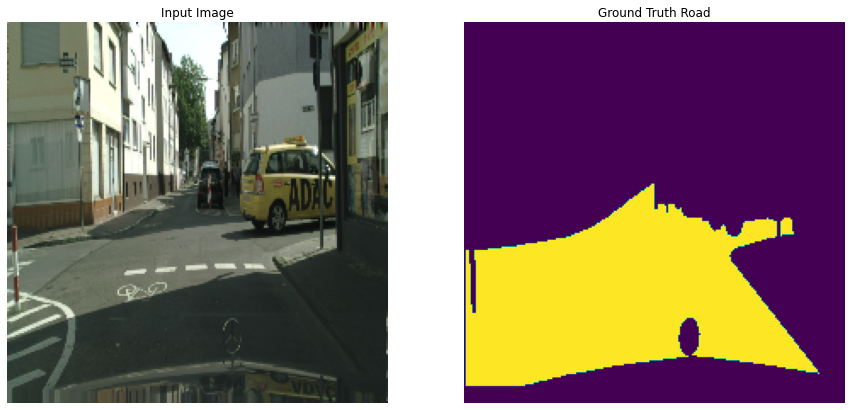

In [7]:
show_sample(test_dataset.batch(temp_batch_size), temp_batch_size)

## Create the Model Architecture

Whether it's an off-the-shelf model or a custom model, ***Masterful works with any model architecture.***
In this guide you'll use an [U-Net](https://arxiv.org/pdf/1505.04597v1.pdf) based network (but it can be replaced with any model you prefer).

In nearly all cases, you should start with an existing model architecture and pretrained weights. It's generally not the case that building a quick simple convnet is an easier place to start - instead, you'll likely run into bugs in your architecture as well as unexpected behaviors. But using a full massive achitecture is not that efficient with your time either when you are just trying to get a project off the ground.

What we suggest is starting the following.

1. Start with a modern architecture that offers multiple sized models. Keras provides EfficientNet, EfficientNetV2, ResNet-RS (in Tensorflow 2.9), and MobileNet for classification. All are great options, and allow you to easily increase your model size as you experiment with the right model size for your application. For detection and segmentation, use one of those architectures as the backbone for your classifier / detection head of choice. In this example, you'll use a U-Net architecture as the detection head. 
2. Always pick a model that has pretrained weights. In most cases, they'll do a lot better than Glorot or He initialized weights. Down the road, you can experiment with unsupervised pretraining to see that technique will further increase your model's accuracy.
3. When you are first getting started, use a small model to speed up your training times. In this case, you'll start with an EfficientNet B0 as the backbone for the U-Net. 

The **segmentation_models** repo provides a U-Net architecture on top of an EfficientNet B0, with pretrained weights. 

In [8]:
try:
    import segmentation_models as sm
except ImportError:
    print("Installing segmentation_models")
    bashCommand = "pip install segmentation_models"
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    output = output.decode("utf-8").strip()
    if error:
        print("Failed to import 'segmentation_models'. Stop further execution")
        print(output)
    else:
        import segmentation_models as sm

def build_unet(input_shape, n_classes):
    
    sm.set_framework('tf.keras')
    backbone = "efficientnetb0"
    preprocess_input = sm.get_preprocessing(backbone)
    model = sm.Unet(
        backbone, classes=n_classes, activation="sigmoid", input_shape=input_shape,
        encoder_weights='imagenet')
    
    return model

model = build_unet(INPUT_SHAPE, n_classes=1)
# print(model.summary())

Segmentation Models: using `tf.keras` framework.


### Check the model output before training

Before you start training, confirm that the model will actually run in inference, and that the predictions are random. 

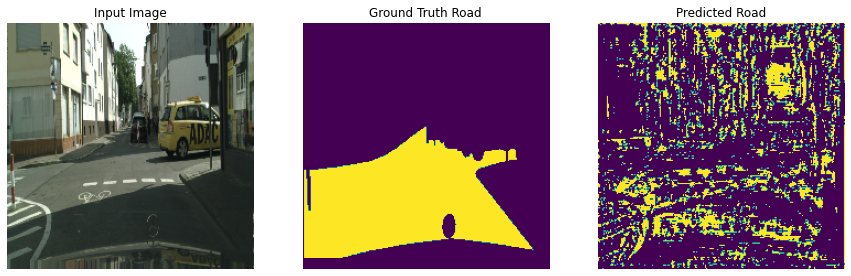

In [9]:
show_sample_and_prediction(
    model,
    test_dataset.batch(temp_batch_size),
    temp_batch_size
)

### Setup The Right Metric

Most CV tasks have standard metrics. Single Label Classification is generally judged on top-1 and top-5 accuracy. Binary classification is generally judged on accuracy, recall, and precision. Detection uses mAP or AP, and for the current task of segmentation, the standard metric is Intersection-Over-Union or IOU. 

In [10]:
threshold = 0.5
class MeanIOUFromLogits(tf.keras.metrics.MeanIoU):

  def update_state(self, y_true, y_pred, sample_weight=None):
    return super().update_state(
        y_true,
        tf.where(
          y_pred >= threshold,
          tf.ones_like(y_pred),
          tf.zeros_like(y_pred)
        ),
        sample_weight
    )

## Setup Masterful to Train Your Model

The Masterful CV platform learns how to train your model by focusing on five core organizational principles in deep learning: architecture, data, optimization, regularization, and semi-supervision.

***Architecture*** is the structure of weights, biases, and activations that define a model. In this example, the architecture is defined by the model you created above.

***Data*** is the input used to train the model. In this example, you are using a labeled training dataset - CIFAR-10. More advanced usages of the Masterful AutoML platform can take into account unlabeled and synthetic data as well, using a variety of different techniques.

***Optimization*** means finding the best weights for a model and training data. Optimization is different from regularization because optimization does not consider generalization to unseen data. The central challenge of optimization is speed - find the best weights faster.

***Regularization*** means helping a model generalize to data it has not yet seen. Another way of saying this is that regularization is about fighting overfitting.

***Semi-Supervision*** is the process by which a model can be trained using both labeled and unlabeled data.

The first step when using Masterful is to learn the optimal set of parameters for each of the five buckets above. You start by learning the architecture and data parameters of the model and training dataset. In the code below, you are telling Masterful that your model is performing a Segmentation task (masterful.enums.Task.SEMANTIC_SEGMENTATION) with 2 classes (num_classes=NUM_CLASSES), and that the input range of the image features going into your model are in the range [0,1] (input_range=masterful.enums.ImageRange.ZERO_ONE). Also, the model outputs logits rather than a softmax classification (prediction_logits=True). For more details on architecture and data parameters, see the API specifications for [ArchitectureParams](https://docs.masterfulai.com/0.4.1/api/api_architecture.html#masterful.architecture.ArchitectureParams) and [DataParams](https://docs.masterfulai.com/0.4.1/api/api_data.html#masterful.data.DataParams).

In [11]:
model_params = masterful.architecture.learn_architecture_params(
  model=model,
  task=masterful.enums.Task.SEMANTIC_SEGMENTATION,
  input_range=masterful.enums.ImageRange.ZERO_ONE,
  num_classes=NUM_CLASSES,
  prediction_logits=False,
)
training_dataset_params = masterful.data.learn_data_params(
  dataset=training_dataset,
  task=masterful.spec.Task.SEMANTIC_SEGMENTATION,
  image_range=masterful.enums.ImageRange.ZERO_ONE,
  num_classes=NUM_CLASSES,
  sparse_labels=False,
)

Next you learn the optimization parameters that will be used to train the model. Below, you use Masterful to learn the standard set of optimization parameters to train your model for a segmentation task. For more details on the optmization parameters, please see the [OptimizationParams](https://docs.masterfulai.com/0.4.1/api/api_optimization.html#masterful.optimization.OptimizationParams) API specification.

In [14]:
optimization_params = masterful.optimization.learn_optimization_params(
    model,
    model_params,
    training_dataset,
    training_dataset_params,
)

MASTERFUL: Learning optimal batch size.
MASTERFUL: Learning optimal initial learning rate for batch size 16.


The regularization parameters used can have a dramatic impact on the final performance of your trained model. Learning these parameters can be a time-consuming and domain specific challenge. Masterful can speed up this process by learning these parameters for you. In general, this can be an expensive operation. A rough order of magnitude for learning these parameters is 2x the time it takes to train your model. However, this is still dramatically faster than manually finding these parameters yourself. In the example below, you will use one of the many sets of pre-learned regularization parameters that are shipped in the Masterful API. In most instances, you should learn these parameters directly using the [learn_regularization_params](https://docs.masterfulai.com/0.4.1/api/api_regularization.html#masterful.regularization.learn_regularization_params) API. For more details on the regularization parameters, please see the [RegularizationParams](https://docs.masterfulai.com/0.4.1/api/api_regularization.html#masterful.regularization.RegularizationParams) API specification.

In [15]:
regularization_params = masterful.regularization.learn_regularization_params(
    model,
    model_params,
    optimization_params,
    training_dataset,
    training_dataset_params,
)

MASTERFUL: Meta-Learning Regularization Parameters...
MASTERFUL: Warming up model for analysis.
MASTERFUL: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL: 	Warming up training for 670 steps.
100%|██████████| 670/670 [04:09<00:00,  2.68steps/s] 
MASTERFUL: 	Validating batch norm statistics after warmup for stability (this could take a few minutes).
MASTERFUL: Analyzing baseline model performance. Training until validation loss stabilizes...
Baseline Training: 100%|██████████| 931/931 [08:56<00:00,  1.74steps/s]
MASTERFUL: Baseline training complete.
MASTERFUL: Meta-Learning Basic Data Augmentations...
Node 4/4: 100%|██████████| 380/380 [03:35<00:00,  1.77steps/s]
MASTERFUL: Meta-Learning Data Augmentation Clusters...
Node 10/10: 100%|██████████| 380/380 [04:08<00:00,  1.53steps/s]
MASTERFUL: Meta-Learning Label Based Regularization...
Node 2/2: 100%|██████████| 380/380 [04:01<00:00,  1.57steps/s]
MASTERFUL: Meta-Learning Weight Based Regularization...
MASTE

The final step before training is to learn the optimal set of semi-supervision parameters. You'll first try with NO unlabeled data, so most forms of semi-supervision will be disabled by default.

In [16]:
ssl_params = masterful.ssl.learn_ssl_params(
    training_dataset,
    training_dataset_params
)

## Training (NO unlabeled data)

Now, you are ready to train your model using the Masterful AutoML platform. In the next cell, you will see the call to [masterful.training.train](https://docs.masterfulai.com/0.4.1/api/api_training.html#masterful.training.train), which is the entry point to the meta-learning engine of the Masterful AutoML platform. Notice there is no need to batch your data (Masterful will find the optimal batch size for you). No need to shuffle your data (Masterful handles this for you). You don’t even need to pass in a validation dataset (Masterful finds one for you). You hand Masterful a model and a dataset, and Masterful will figure the rest out for you.

In [17]:
# Append your binaryIOU metric
optimization_params.metrics.append(MeanIOUFromLogits(num_classes=2, name='iou'))

In [18]:
training_report = masterful.training.train(
    model=model,
    model_params=model_params,
    training_dataset=training_dataset,
    training_dataset_params=training_dataset_params,
    optimization_params=optimization_params,
    regularization_params=regularization_params,
    ssl_params=ssl_params
)

MASTERFUL: Training model with semi-supervised learning disabled.
MASTERFUL: Performing basic dataset analysis.
MASTERFUL: Masterful will use 29 labeled examples as a validation set since no validation data was provided.
MASTERFUL: Training model with:
MASTERFUL: 	268 labeled examples.
MASTERFUL: 	29 validation examples.
MASTERFUL: 	0 synthetic examples.
MASTERFUL: 	0 unlabeled examples.
MASTERFUL: Training model with learned parameters trader-utopian-tracker in two phases.
MASTERFUL: The first phase is supervised training with the learned parameters.
MASTERFUL: The second phase is semi-supervised training to boost performance.
MASTERFUL: Warming up model for supervised training.
MASTERFUL: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL: 	Warming up training for 670 steps.
100%|██████████| 670/670 [05:09<00:00,  2.16steps/s] 
MASTERFUL: 	Validating batch norm statistics after warmup for stability (this could take a few minutes).
MASTERFUL: Starting Phase 1

In [19]:
train_loss, train_acc, train_iou = model.evaluate(
    training_dataset.batch(optimization_params.batch_size),
    verbose = 0
)
test_loss, test_acc, test_iou = model.evaluate(
    test_dataset.batch(optimization_params.batch_size),
    verbose = 0
)

print(f'Post Training: \n'
      f'Model loss on Traning set = {train_loss:.4f}, test set = {test_loss:.4f}\n'
      f'Model accuracy on Traning set = {train_acc:.4f}, test set = {test_acc:4f}\n'
      f'Model IOU on Traning set = {train_iou:.4f}, test set = {test_iou:4f}')

Post Training: 
Model loss on Traning set = 0.0522, test set = 0.2025
Model accuracy on Traning set = 0.9796, test set = 0.942859
Model IOU on Traning set = 0.9545, test set = 0.877095


### Visualize model output after training

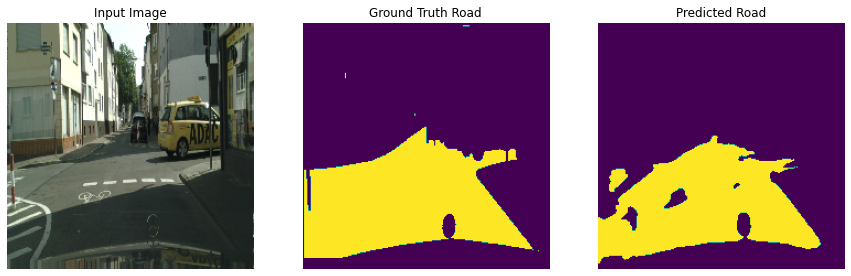

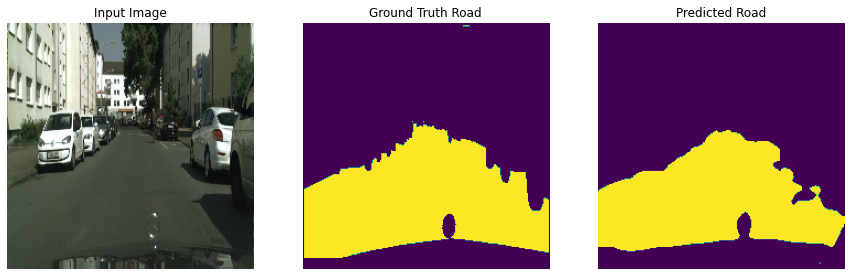

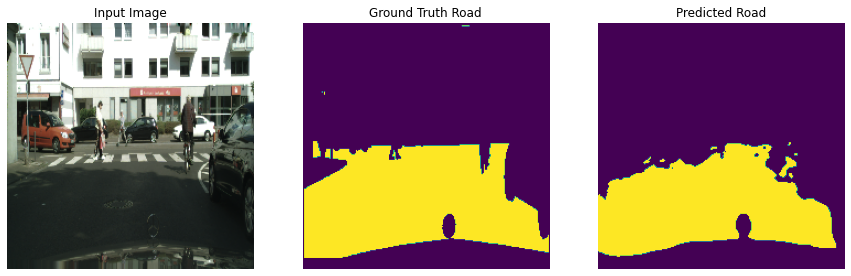

In [21]:
show_sample_and_prediction(
    model,
    test_dataset.batch(temp_batch_size),
    3,
)

### Saving the trained model

After the model training is complete, you want to save the model to use it in the next step for inference.

For this current step and all the following ones, you'll need to run the steps locally to allow sharing your saved trained model
with the deployment system you'll learn how to build next.

We're going to create a new directory to store our saved models and organize them by versions. Versioning is critical in ML deployment,
as you'll keep deploying newer, improved versions of your model that have been trained better, and tracking the performance of each version
in production is important. Tensorflow Serving system also expects your model output directory to be organized by versions, otherwise
it'll throw an error.

Below we'll create a directory for storing the model and since it's the first model, it'll be v1.

In [23]:
import pathlib

# The directory where the model will be saved. 
MODEL_DIR = f'{os.path.expanduser("~")}/model_output_dir'

# This leaf directory '1' refers to the version. Next model would be saved at `.../2/`.
V1_DIR = f'{MODEL_DIR}/1'

pathlib.Path(V1_DIR).mkdir(parents=True, exist_ok=True)
model.save(V1_DIR)

INFO:tensorflow:Assets written to: /home/ubuntu/model_output_dir/1/assets


The output directory where the model is saved will include several artifacts. The importants ones for
the next step are 'saved_model.pb' and the variables folder.

## Deploying the trained model

Now that you've trained a model with a satisfactory performance and saved it, it's time to test deployment. 

In this section, you'll use [Tensorflow Serving](https://github.com/tensorflow/serving) to serve
your model and expose a REST API endpoint to call for prediction requests. 

Tensorflow models are often served with [Tensorflow Serving](https://github.com/tensorflow/serving), which is Tensorflow's
official serving system that manages versioning. Tensorflow Serving is integrated into major cloud providers like [AWS](https://docs.aws.amazon.com/dlami/latest/devguide/tutorial-tfserving.html) and is built with Docker, making it ready to autoscale in the cloud with the standard combination of Kubernetes and Docker. 

To run the rest of this example, [install Docker](https://www.docker.com/get-started/). 

**Note*:: Due to a known issue, Docker is not supported on Google Collab. 

Once you have Docker installed, pull the latest TensorFlow Serving docker image. 

### Setup some command line utilities

In [27]:
def exec_command(bashCommand, wait_to_finish=True):
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    if not wait_to_finish:
        return b"",""
    output, error = process.communicate()
    return output.decode("utf-8").strip(), error

def docker_image_exists(docker_image_name="tensorflow/serving"):
    bashCommand = f"docker image inspect {docker_image_name}"
    output, error = exec_command(bashCommand)
    return output != '[]'

def delete_docker_image(docker_image_name="tensorflow/serving"):
    bashCommand = f"docker image rm {docker_image_name}"
    output, error = exec_command(bashCommand)
    if error:
        print(f"Docker: Failed to delete image '{docker_image_name}'") 
    else:
        print(f"Deleted Docker image '{docker_image_name}'")

def docker_pull_image(docker_image_name):
    bashCommand = f"docker pull {docker_image_name}"
    output, error = exec_command(bashCommand)
    if error:
        print(f"Docker: Failed to pull image '{docker_image_name}'")
    else:
        print(f"Docker pulled '{docker_image_name}'")

def container_exists(container_name="sli_api"):
    bashCommand = f"docker container inspect {container_name}"
    output, error = exec_command(bashCommand)
    return output != '[]'

def delete_docker_container(container_name="sli_api"):
    for bashCommand in [
        f"docker stop {container_name}",
        f"docker rm -f {container_name}",
    ]:
        output, error = exec_command(bashCommand)
        if error:
            print(f"Failed to execute '{bashCommand}'")
            return
        if 'stop' in bashCommand:
            print(f"Stopped old container '{container_name}'")
        else:
            print(f"Removed old container '{container_name}'")

def docker_run(container_name, MODEL_DIR):
    bashCommand = (f"docker run --name={container_name} -p 8501:8501 "
                   f"--mount type=bind,source={MODEL_DIR},target=/models/my_model "
                   f"-e MODEL_NAME=my_model -t tensorflow/serving")
    _, _ = exec_command(bashCommand, wait_to_finish=False)

### Docker pull latest TensorFlow Serving image and start a container
Run the docker image and bind the trained model. Your model is now running as a service, and accessible at localhost:8501 via a REST API. 

In [29]:
# delete any stale container if it exists
docker_image_name = "tensorflow/serving"
container_name = "sli_api"

if container_exists(container_name):
    print(f"Found previous docker container '{container_name}'")
    delete_docker_container(container_name)

# Once you have Docker installed,
# pull the latest TensorFlow Serving docker image. 
if not docker_image_exists(docker_image_name):
    docker_pull_image(docker_image_name)
    
# start a new docker container
print(f"Started a new docker container '{container_name}'"
      f" to run your model as a service")
docker_run(container_name, MODEL_DIR)

Docker pulled 'tensorflow/serving'
Started a new docker container 'sli_api' to run your model as a service



## Testing Client Side Access to the Service

The final step left is to call the inference API! For this you'll need to send a request to the REST API with an image to get a prediction back. 

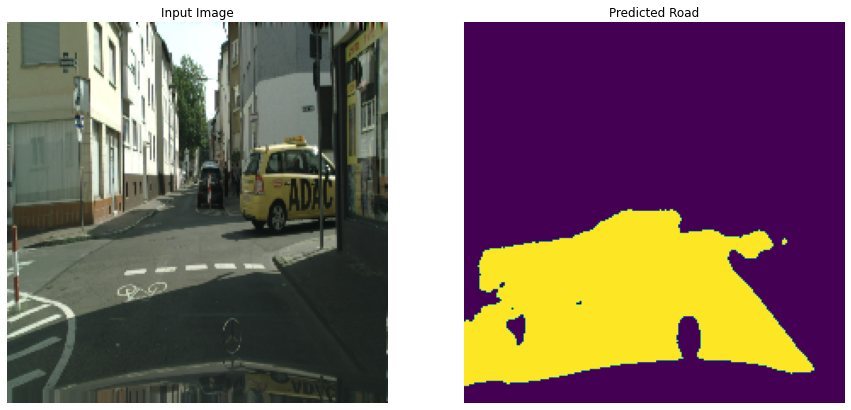

In [30]:
import requests

IMAGE_FILE = test['image'][0]

# The endpoint to send inference requests to. Notice the 'v1' in the URL,
# this was added by Tensorflow Serving automatically to signal the version
# of the served mode.
ENDPOINT = "http://localhost:8501/v1/models/my_model:predict"

# Processing the sample image in the same way as earlier.
image = tf.io.decode_image(open(IMAGE_FILE, 'rb').read(), channels=3)
image = tf.image.resize(image, [224, 224])
image = tf.cast(image, tf.float32) / 255.0

# Preparing the inference request.
image = tf.expand_dims(image, 0)
json_data = {"instances": image.numpy().tolist()}

# Calling the endpoint for a prediction.
response = requests.post(ENDPOINT, json=json_data)

# Plotting the predicted image in the response.
prediction = response.json()['predictions']
prediction = np.asarray(prediction[0])

# Display predicted road
image = image[0]
prediction = prediction > 0.5
prediction = tf.cast(255.0 * prediction, tf.uint8)
display([image, prediction], pred=True)


## Delete docker container and image

In [31]:
if container_exists(container_name):
    print(f"Docker container '{container_name}' exists")
    delete_docker_container(container_name)
else:
    print(f"Docker container '{container_name}' does not exist")

Docker container 'sli_api' exists
Stopped old container 'sli_api'
Removed old container 'sli_api'


In [32]:
if docker_image_exists(docker_image_name):
    print(f"Docker image '{docker_image_name}' exists")
    delete_docker_image(docker_image_name)
else:
    print(f"Docker image '{docker_image_name}' does not exist")

Docker image 'tensorflow/serving' exists
Deleted Docker image 'tensorflow/serving'


Congratulations! In this guide, you defined an application, you acquired and prepared data, you trained a model, and you deployed it as a service. 